In [ ]:
import os
from rasterio.enums import Resampling
from snow_processing import reproject_resample_visualize,

# === Step 1: Reproject & Resample all .img files from 2022 and 2023 ===

input_base = r"F:\GeoinformaticsProject\Data\MODIS_SnowMask"
resampled_output = r"F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\MODIS"
os.makedirs(resampled_output, exist_ok=True)

# Loop through both years
for year in ['2022', '2023']:
    year_path = os.path.join(input_base, year)
    for fname in os.listdir(year_path):
        if fname.endswith('.img') and fname.startswith('neve_'):
            src_path = os.path.join(year_path, fname)
            base_name = os.path.splitext(fname)[0]
            dst_name = f"RR-{base_name}.tif"
            dst_path = os.path.join(resampled_output, dst_name)

            reproject_resample_visualize(
                src_path=src_path,
                dst_path=dst_path,
                dst_crs='EPSG:32632',
                dst_res=(20, 20),
                resampling_method=Resampling.nearest,
                visualize=False
            )


f:\GeoinformaticsProject\Code\snow_processing.py:40: SyntaxWarning: invalid escape sequence '\M'
  """


KeyboardInterrupt: 

In [1]:
import os
from snow_processing import aggregate_weekly

resampled_modis = r"F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\MODIS"
weekly_modis   = r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\MODIS"

print("\n▶️ Aggregating weekly for MODIS")
aggregate_weekly(
    directory     = resampled_modis,
    pattern       = '.tif',      # all binary MODIS .tif files
    output_dir    = weekly_modis,
    method        = 'max',
    threshold     = 0.5,        # keep raw 0/1
    qc_suffix     = '_QC.tif',   # no effect (no QC files)
    skip_existing = False,
    summary       = True,
    parallel      = True,
    max_workers   = 1
)


f:\GeoinformaticsProject\Code\Snow\snow_processing.py:47: SyntaxWarning: invalid escape sequence '\M'
  """



▶️ Aggregating weekly for MODIS
📦 Aggregating 1 → 2021_W51 (max)
📦 Aggregating 2 → 2022_W52 (max)
📦 Aggregating 2 → 2022_W02 (max)
📦 Aggregating 2 → 2022_W04 (max)
📦 Aggregating 1 → 2022_W06 (max)
📦 Aggregating 1 → 2022_W07 (max)
📦 Aggregating 1 → 2022_W08 (max)
📦 Aggregating 1 → 2022_W09 (max)
📦 Aggregating 1 → 2022_W10 (max)
📦 Aggregating 1 → 2022_W11 (max)
📦 Aggregating 2 → 2022_W12 (max)
📦 Aggregating 2 → 2022_W14 (max)
📦 Aggregating 1 → 2022_W16 (max)
📦 Aggregating 1 → 2022_W17 (max)
📦 Aggregating 1 → 2022_W19 (max)
📦 Aggregating 1 → 2022_W43 (max)
📦 Aggregating 1 → 2022_W44 (max)
📦 Aggregating 1 → 2022_W47 (max)
📦 Aggregating 1 → 2022_W49 (max)
📦 Aggregating 2 → 2022_W50 (max)
📦 Aggregating 1 → 2023_W02 (max)
📦 Aggregating 1 → 2023_W04 (max)
📦 Aggregating 2 → 2023_W06 (max)
📦 Aggregating 1 → 2023_W08 (max)
📦 Aggregating 1 → 2023_W09 (max)
📦 Aggregating 1 → 2023_W10 (max)
📦 Aggregating 1 → 2023_W11 (max)
📦 Aggregating 1 → 2023_W13 (max)
📦 Aggregating 1 → 2023_W14 (max)
📦 Aggregat

['F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\MODIS\\2021_W51.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\MODIS\\2022_W52.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\MODIS\\2022_W02.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\MODIS\\2022_W04.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\MODIS\\2022_W06.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\MODIS\\2022_W07.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\MODIS\\2022_W08.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\MODIS\\2022_W09.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\MODIS\\2022_W10.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\MODIS\\2022_W11.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\MODIS\\2022_W12.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\MODIS\\2022_W14.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\MODIS\\2022_W16.tif',
 'F:\\Geoinf

In [2]:
import os
import rasterio
import numpy as np
import pandas as pd
from datetime import datetime

modis_dir = r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\MODIS"
summary = []

for fname in os.listdir(modis_dir):
    if not fname.endswith('.tif'):
        continue
    path = os.path.join(modis_dir, fname)
    try:
        with rasterio.open(path) as src:
            data = src.read(1)
            nodata = src.nodata
            valid_pixels = np.sum(data != nodata)
            unique_vals = np.unique(data)
            size_kb = os.path.getsize(path) / 1024

        date_str = ''.join([c for c in fname if c.isdigit()])[:8]
        date = pd.to_datetime(date_str, format="%Y%m%d", errors='coerce')
        week = date.isocalendar().week if date is not pd.NaT else 'Unknown'

        summary.append({
            "filename": fname,
            "size_kb": round(size_kb, 1),
            "shape": data.shape,
            "unique_values": unique_vals.tolist(),
            "valid_pixels": int(valid_pixels),
            "week": week
        })

    except Exception as e:
        summary.append({
            "filename": fname,
            "error": str(e)
        })

df = pd.DataFrame(summary)
print(df.to_string())


        filename   size_kb           shape unique_values  valid_pixels     week
0   2021_W51.tif  733780.3  (25023, 30022)        [0, 1]     751240506       17
1   2022_W02.tif  733780.3  (25023, 30022)        [0, 1]     751240506  Unknown
2   2022_W04.tif  733780.3  (25023, 30022)        [0, 1]     751240506  Unknown
3   2022_W06.tif  733780.3  (25023, 30022)        [0, 1]     751240506  Unknown
4   2022_W07.tif  733780.3  (25023, 30022)        [0, 1]     751240506  Unknown
5   2022_W08.tif  733780.3  (25023, 30022)        [0, 1]     751240506  Unknown
6   2022_W09.tif  733780.3  (25023, 30022)        [0, 1]     751240506  Unknown
7   2022_W10.tif  733780.3  (25023, 30022)        [0, 1]     751240506  Unknown
8   2022_W11.tif  733780.3  (25023, 30022)        [0, 1]     751240506       52
9   2022_W12.tif  733780.3  (25023, 30022)        [0, 1]     751240506       52
10  2022_W14.tif  733780.3  (25023, 30022)        [0, 1]     751240506        1
11  2022_W16.tif  733780.3  (25023, 3002

In [3]:

import os, glob
from rasterio.enums import Resampling
from snow_processing import reproject_resample_visualize, aggregate_weekly

# ── 1. SETTINGS ───────────────────────────────────────────────────────────────
raw_gfsc_root   = r"F:\GeoinformaticsProject\Data\GFSC\GFSC"        
resampled_dir   = r"F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\GFSC"
weekly_dir      = r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\GFSC"

dst_crs         = "EPSG:32632"
dst_res         = (20, 20)      # target 20 m

os.makedirs(resampled_dir, exist_ok=True)
os.makedirs(weekly_dir, exist_ok=True)

# ── 2. REPROJECT & RESAMPLE GF + QC ──────────────────────────────────────────
for tile in os.listdir(raw_gfsc_root):
    tile_dir = os.path.join(raw_gfsc_root, tile)
    if not os.path.isdir(tile_dir):
        continue

    # find each GF file + its QC partner
    for gf_fname in glob.glob(os.path.join(tile_dir, "*_GF.tif")):
        qc_fname = gf_fname.replace("_GF.tif", "_QC.tif")
        if not os.path.exists(qc_fname):
            print(f"⚠️  Missing QC for {gf_fname}, skipping QC.")
        
        # output paths
        out_gf = os.path.join(resampled_dir, os.path.basename(gf_fname))
        out_qc = os.path.join(resampled_dir, os.path.basename(qc_fname))

        # GF: continuous → bilinear
        if not os.path.exists(out_gf):
            reproject_resample_visualize(
                src_path         = gf_fname,
                dst_path         = out_gf,
                dst_crs          = dst_crs,
                dst_res          = dst_res,
                resampling_method = Resampling.bilinear,
                visualize        = False
            )

        # QC: categorical → nearest
        if os.path.exists(qc_fname) and not os.path.exists(out_qc):
            reproject_resample_visualize(
                src_path         = qc_fname,
                dst_path         = out_qc,
                dst_crs          = dst_crs,
                dst_res          = dst_res,
                resampling_method = Resampling.nearest,
                visualize        = False
            )

# ── 3. WEEKLY AGGREGATION WITH 20% THRESHOLD ─────────────────────────────────
aggregate_weekly(
    directory    = resampled_dir,
    pattern      = '_GF.tif',    # ← only the fractional-snow layer
    output_dir   = weekly_dir,
    method       = 'max',
    threshold    = 20,
    qc_suffix    = '_QC.tif',
    skip_existing= True,
    summary      = True,
    parallel     = True,
    max_workers  = 6
)


✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\GFSC\20211107_GF.tif
✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\GFSC\20211107_QC.tif
✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\GFSC\20211114_GF.tif
✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\GFSC\20211114_QC.tif
✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\GFSC\20211121_GF.tif
✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\GFSC\20211121_QC.tif
✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\GFSC\20211128_GF.tif
✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\GFSC\20211128_QC.tif
✅ Resampled and reprojected save

['F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\GFSC\\2021_W46.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\GFSC\\2021_W44.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\GFSC\\2021_W49.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\GFSC\\2021_W45.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\GFSC\\2021_W47.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\GFSC\\2021_W48.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\GFSC\\2021_W50.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\GFSC\\2022_W52.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\GFSC\\2022_W01.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\GFSC\\2022_W03.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\GFSC\\2022_W02.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\GFSC\\2021_W51.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\GFSC\\2022_W04.tif',
 'F:\\GeoinformaticsProje

In [ ]:
from snow_processing import split_and_reproject_s2_biweeks

# ===  Reproject & Resample all S2 ===

split_and_reproject_s2_biweeks(
    input_dir=r"F:\GeoinformaticsProject\Data\S2\S2\SnowMask",
    temp_dir=r"F:\GeoinformaticsProject\Data\Temp\S2-Split",
    output_dir=r"F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\S2",
    visualize=False
)


f:\GeoinformaticsProject\Code\snow_processing.py:40: SyntaxWarning: invalid escape sequence '\M'
  """


⏭ Skipping 20220103_20220116_SnowMask_latest — outputs already exist.
⏭ Skipping 20220117_20220130_SnowMask_latest — outputs already exist.
⏭ Skipping 20220131_20220213_SnowMask_latest — outputs already exist.
⏭ Skipping 20220214_20220227_SnowMask_latest — outputs already exist.
⏭ Skipping 20220228_20220313_SnowMask_latest — outputs already exist.
⏭ Skipping 20220314_20220327_SnowMask_latest — outputs already exist.
⏭ Skipping 20220328_20220410_SnowMask_latest — outputs already exist.
⏭ Skipping 20220411_20220424_SnowMask_latest — outputs already exist.
⏭ Skipping 20221003_20221016_SnowMask_latest — outputs already exist.
⏭ Skipping 20221017_20221030_SnowMask_latest — outputs already exist.
⏭ Skipping 20221031_20221113_SnowMask_latest — outputs already exist.
⏭ Skipping 20221114_20221127_SnowMask_latest — outputs already exist.
⏭ Skipping 20221128_20221211_SnowMask_latest — outputs already exist.
⏭ Skipping 20221205_20221218_SnowMask_latest — outputs already exist.
⏭ Skipping 20221212_

f:\GeoinformaticsProject\Code\snow_processing.py:264: RuntimeWarning: All-NaN slice encountered
  result = np.nanmax(data_stack, axis=0)


📦 Aggregating 2 files for 2022_W13 using 'max'
📦 Aggregating 2 files for 2022_W15 using 'max'
📦 Aggregating 2 files for 2022_W40 using 'max'📦 Aggregating 2 files for 2022_W42 using 'max'

📦 Aggregating 2 files for 2022_W44 using 'max'
📦 Aggregating 2 files for 2022_W46 using 'max'
📦 Aggregating 2 files for 2022_W48 using 'max'
📦 Aggregating 2 files for 2022_W49 using 'max'
📦 Aggregating 2 files for 2022_W50 using 'max'
📦 Aggregating 2 files for 2022_W52 using 'max'
📦 Aggregating 2 files for 2023_W02 using 'max'
📦 Aggregating 2 files for 2023_W03 using 'max'
📦 Aggregating 2 files for 2023_W04 using 'max'
📦 Aggregating 2 files for 2023_W05 using 'max'
📦 Aggregating 2 files for 2023_W06 using 'max'📦 Aggregating 2 files for 2023_W07 using 'max'

📦 Aggregating 2 files for 2023_W08 using 'max'
📦 Aggregating 2 files for 2023_W09 using 'max'
📦 Aggregating 2 files for 2023_W10 using 'max'
📦 Aggregating 2 files for 2023_W11 using 'max'
📦 Aggregating 2 files for 2023_W12 using 'max'
📦 Aggregating

['F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S2\\2022_W11.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S2\\2022_W01.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S2\\2022_W05.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S2\\2022_W07.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S2\\2022_W09.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S2\\2022_W03.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S2\\2022_W13.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S2\\2022_W46.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S2\\2022_W48.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S2\\2022_W49.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S2\\2022_W50.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S2\\2022_W52.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S2\\2023_W02.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKL

In [ ]:
import os
import sys
from rasterio.enums import Resampling
from snow_processing import reproject_resample_visualize

# === Paths ===
input_dir = r"F:\GeoinformaticsProject\Data\S3\S3\SnowMask"
resampled_dir = r"F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\S3"
weekly_dir = r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\S3"

# === Step 1: Resample & Reproject all S3 masks ===
input_files = [f for f in os.listdir(input_dir) if f.endswith('.tif') and '_datemap' not in f]

for fname in input_files:
    src_path = os.path.join(input_dir, fname)
    dst_path = os.path.join(resampled_dir, f"RR-{fname}")
    
    reproject_resample_visualize(
        src_path=src_path,
        dst_path=dst_path,
        dst_crs="EPSG:32632",
        dst_res=(300, 300),
        resampling_method=Resampling.nearest,
        visualize=False
    )


✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\S3\RR-20220103_20220109_SnowMask(0.42)_latest.tif
✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\S3\RR-20220110_20220116_SnowMask(0.42)_latest.tif
✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\S3\RR-20220117_20220123_SnowMask(0.42)_latest.tif
✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\S3\RR-20220124_20220130_SnowMask(0.42)_latest.tif
✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\S3\RR-20220131_20220206_SnowMask(0.42)_latest.tif
✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\S3\RR-20220207_20220213_SnowMask(0.42)_latest.tif
✅ Resampled and reprojected saved to: F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\

f:\GeoinformaticsProject\Code\snow_processing.py:271: RuntimeWarning: All-NaN slice encountered
  result = np.nanmax(data_stack, axis=0)


📦 Aggregating 1 files for 2022_W07 using 'max'📦 Aggregating 1 files for 2022_W08 using 'max'

📦 Aggregating 1 files for 2022_W10 using 'max'
📦 Aggregating 1 files for 2022_W09 using 'max'
📦 Aggregating 1 files for 2022_W11 using 'max'
📦 Aggregating 1 files for 2022_W12 using 'max'
📦 Aggregating 1 files for 2022_W40 using 'max'
📦 Aggregating 1 files for 2022_W41 using 'max'
📦 Aggregating 1 files for 2022_W43 using 'max'
📦 Aggregating 1 files for 2022_W42 using 'max'
📦 Aggregating 1 files for 2022_W44 using 'max'
📦 Aggregating 1 files for 2022_W45 using 'max'
📦 Aggregating 1 files for 2022_W46 using 'max'📦 Aggregating 1 files for 2022_W47 using 'max'

📦 Aggregating 1 files for 2022_W48 using 'max'
📦 Aggregating 1 files for 2022_W49 using 'max'
📦 Aggregating 1 files for 2022_W50 using 'max'
📦 Aggregating 1 files for 2023_W03 using 'max'
📦 Aggregating 1 files for 2023_W04 using 'max'
📦 Aggregating 1 files for 2023_W05 using 'max'
📦 Aggregating 1 files for 2023_W06 using 'max'
📦 Aggregating

In [4]:
from snow_processing import aggregate_weekly

# — S2 weekly (no extra threshold) —
aggregate_weekly(
    directory     = r"F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\S2",
    pattern       = '.tif',       # picks up your binary S2 masks
    output_dir    = r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\S2",
    method        = 'max',        # 1 if any day in the week was snow
    threshold     = None,         # keep the raw 0/1 values
    qc_suffix     = '_QC.tif',    # if you have QC files, else this does nothing
    skip_existing = False,
    summary       = True,
    parallel      = True,
    max_workers   = 4
)

# — S3 weekly (same) —
aggregate_weekly(
    directory     = r"F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\S3",
    pattern       = '.tif',
    output_dir    = r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\S3",
    method        = 'max',
    threshold     = None,
    qc_suffix     = '_QC.tif',
    skip_existing = False,
    summary       = True,
    parallel      = True,
    max_workers   = 4
)


📦 Aggregating 2 → 2022_W01 (max)
📦 Aggregating 2 → 2022_W03 (max)
📦 Aggregating 2 → 2022_W05 (max)
📦 Aggregating 2 → 2022_W07 (max)
📦 Aggregating 2 → 2022_W09 (max)
📦 Aggregating 2 → 2022_W11 (max)
📦 Aggregating 2 → 2022_W13 (max)
📦 Aggregating 2 → 2022_W15 (max)
📦 Aggregating 2 → 2022_W40 (max)
📦 Aggregating 2 → 2022_W42 (max)
📦 Aggregating 2 → 2022_W44 (max)
📦 Aggregating 2 → 2022_W46 (max)
📦 Aggregating 2 → 2022_W48 (max)
📦 Aggregating 2 → 2022_W49 (max)
📦 Aggregating 2 → 2022_W50 (max)
📦 Aggregating 2 → 2022_W52 (max)
📦 Aggregating 2 → 2023_W02 (max)
📦 Aggregating 2 → 2023_W03 (max)
📦 Aggregating 2 → 2023_W04 (max)
📦 Aggregating 2 → 2023_W05 (max)
📦 Aggregating 2 → 2023_W06 (max)
📦 Aggregating 2 → 2023_W07 (max)
📦 Aggregating 2 → 2023_W08 (max)
📦 Aggregating 2 → 2023_W09 (max)
📦 Aggregating 2 → 2023_W10 (max)
📦 Aggregating 2 → 2023_W11 (max)
📦 Aggregating 2 → 2023_W12 (max)
📦 Aggregating 2 → 2023_W13 (max)
📦 Aggregating 2 → 2023_W14 (max)
📦 Aggregating 2 → 2023_W15 (max)
📦 Aggregat

['F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S3\\2022_W02.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S3\\2022_W04.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S3\\2022_W03.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S3\\2022_W01.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S3\\2022_W07.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S3\\2022_W06.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S3\\2022_W05.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S3\\2022_W08.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S3\\2022_W09.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S3\\2022_W11.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S3\\2022_W12.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S3\\2022_W10.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKLY\\S3\\2022_W40.tif',
 'F:\\GeoinformaticsProject\\Data\\Processed\\WEEKL

In [5]:
from snow_processing import check_all_products_side_by_side
import pandas as pd

# Define your raw input folders
product_folders = [
    ("MODIS", r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\MODIS", False),
    ("GFSC",  r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\GFSC", True),
    ("S2", r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\S2", False),
    ("S3",    r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\S3", False),
]

# Run the check
df = check_all_products_side_by_side(product_folders, start_year=2022, end_year=2023)

# Show all weeks
pd.set_option("display.max_rows", None)
display(df)


🔍 Scanning MODIS → F:\GeoinformaticsProject\Data\Processed\WEEKLY\MODIS
   ➤ Found 32 unique weeks
🔍 Scanning GFSC → F:\GeoinformaticsProject\Data\Processed\WEEKLY\GFSC
   ➤ Found 51 unique weeks
🔍 Scanning S2 → F:\GeoinformaticsProject\Data\Processed\WEEKLY\S2
   ➤ Found 31 unique weeks
🔍 Scanning S3 → F:\GeoinformaticsProject\Data\Processed\WEEKLY\S3
   ➤ Found 39 unique weeks


,Week,MODIS,GFSC,S2,S3,Common_Week
0,2022_W01,❌,✅,✅,✅,
1,2022_W02,✅,✅,❌,✅,
2,2022_W03,❌,✅,✅,✅,
3,2022_W04,✅,✅,❌,✅,
4,2022_W05,❌,✅,✅,✅,
5,2022_W06,✅,✅,❌,✅,
6,2022_W07,✅,✅,✅,✅,✅
7,2022_W08,✅,✅,❌,✅,
8,2022_W09,✅,✅,✅,✅,✅
9,2022_W10,✅,✅,❌,✅,


In [3]:
import os
from snow_processing import match_raster_grid
from rasterio.enums import Resampling

# ── 1. Define only the weeks you actually want to align ────────────────────
common_weeks = [
    '2022_W07', '2022_W09', '2022_W11',
    '2022_W44', '2022_W49', '2022_W50',
    '2023_W04', '2023_W06', '2023_W08',
    '2023_W09', '2023_W10', '2023_W11',
    '2023_W13', '2023_W14', '2023_W15', '2023_W17'
]

# ── 2. Paths ───────────────────────────────────────────────────────────────
weekly_modis_ref = r"F:/GeoinformaticsProject/Data/Processed/WEEKLY/MODIS"
aligned_base     = r"E:\ALIGNED\ToMODIS"
os.makedirs(aligned_base, exist_ok=True)

# ── 3. Align only those weeks for GFSC, S2 and S3 ─────────────────────────
for product in ["GFSC", "S2", "S3"]:
    src_folder = rf"F:/GeoinformaticsProject/Data/Processed/WEEKLY/{product}"
    dst_folder = os.path.join(aligned_base, product)
    os.makedirs(dst_folder, exist_ok=True)

    for week in common_weeks:
        src_path = os.path.join(src_folder, f"{week}.tif")
        ref_path = os.path.join(weekly_modis_ref, f"{week}.tif")
        out_path = os.path.join(dst_folder,   f"{week}.tif")

        # skip if either input is missing or output already exists
        if not os.path.exists(src_path) or not os.path.exists(ref_path) or os.path.exists(out_path):
            continue

        match_raster_grid(
            reference_path   = ref_path,
            target_path      = src_path,
            output_path      = out_path,
            resampling_method= Resampling.nearest
        )
        print(f"Aligned {product} {week} → {out_path}")


✅ Reprojected to match: E:\ALIGNED\ToMODIS\GFSC\2022_W07.tif
Aligned GFSC 2022_W07 → E:\ALIGNED\ToMODIS\GFSC\2022_W07.tif
✅ Reprojected to match: E:\ALIGNED\ToMODIS\GFSC\2022_W09.tif
Aligned GFSC 2022_W09 → E:\ALIGNED\ToMODIS\GFSC\2022_W09.tif
✅ Reprojected to match: E:\ALIGNED\ToMODIS\GFSC\2022_W11.tif
Aligned GFSC 2022_W11 → E:\ALIGNED\ToMODIS\GFSC\2022_W11.tif
✅ Reprojected to match: E:\ALIGNED\ToMODIS\GFSC\2022_W44.tif
Aligned GFSC 2022_W44 → E:\ALIGNED\ToMODIS\GFSC\2022_W44.tif
✅ Reprojected to match: E:\ALIGNED\ToMODIS\GFSC\2022_W49.tif
Aligned GFSC 2022_W49 → E:\ALIGNED\ToMODIS\GFSC\2022_W49.tif
✅ Reprojected to match: E:\ALIGNED\ToMODIS\GFSC\2022_W50.tif
Aligned GFSC 2022_W50 → E:\ALIGNED\ToMODIS\GFSC\2022_W50.tif
✅ Reprojected to match: E:\ALIGNED\ToMODIS\GFSC\2023_W04.tif
Aligned GFSC 2023_W04 → E:\ALIGNED\ToMODIS\GFSC\2023_W04.tif
✅ Reprojected to match: E:\ALIGNED\ToMODIS\GFSC\2023_W06.tif
Aligned GFSC 2023_W06 → E:\ALIGNED\ToMODIS\GFSC\2023_W06.tif
✅ Reprojected to match: 

c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2022_W07.tif
Aligned S2 2022_W07 → E:\ALIGNED\ToMODIS\S2\2022_W07.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2022_W09.tif
Aligned S2 2022_W09 → E:\ALIGNED\ToMODIS\S2\2022_W09.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2022_W11.tif
Aligned S2 2022_W11 → E:\ALIGNED\ToMODIS\S2\2022_W11.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2022_W44.tif
Aligned S2 2022_W44 → E:\ALIGNED\ToMODIS\S2\2022_W44.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2022_W49.tif
Aligned S2 2022_W49 → E:\ALIGNED\ToMODIS\S2\2022_W49.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2022_W50.tif
Aligned S2 2022_W50 → E:\ALIGNED\ToMODIS\S2\2022_W50.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2023_W04.tif
Aligned S2 2023_W04 → E:\ALIGNED\ToMODIS\S2\2023_W04.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2023_W06.tif
Aligned S2 2023_W06 → E:\ALIGNED\ToMODIS\S2\2023_W06.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2023_W08.tif
Aligned S2 2023_W08 → E:\ALIGNED\ToMODIS\S2\2023_W08.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2023_W09.tif
Aligned S2 2023_W09 → E:\ALIGNED\ToMODIS\S2\2023_W09.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2023_W10.tif
Aligned S2 2023_W10 → E:\ALIGNED\ToMODIS\S2\2023_W10.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2023_W11.tif
Aligned S2 2023_W11 → E:\ALIGNED\ToMODIS\S2\2023_W11.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2023_W13.tif
Aligned S2 2023_W13 → E:\ALIGNED\ToMODIS\S2\2023_W13.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2023_W14.tif
Aligned S2 2023_W14 → E:\ALIGNED\ToMODIS\S2\2023_W14.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2023_W15.tif
Aligned S2 2023_W15 → E:\ALIGNED\ToMODIS\S2\2023_W15.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S2\2023_W17.tif
Aligned S2 2023_W17 → E:\ALIGNED\ToMODIS\S2\2023_W17.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2022_W07.tif
Aligned S3 2022_W07 → E:\ALIGNED\ToMODIS\S3\2022_W07.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2022_W09.tif
Aligned S3 2022_W09 → E:\ALIGNED\ToMODIS\S3\2022_W09.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2022_W11.tif
Aligned S3 2022_W11 → E:\ALIGNED\ToMODIS\S3\2022_W11.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2022_W44.tif
Aligned S3 2022_W44 → E:\ALIGNED\ToMODIS\S3\2022_W44.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2022_W49.tif
Aligned S3 2022_W49 → E:\ALIGNED\ToMODIS\S3\2022_W49.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2022_W50.tif
Aligned S3 2022_W50 → E:\ALIGNED\ToMODIS\S3\2022_W50.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2023_W04.tif
Aligned S3 2023_W04 → E:\ALIGNED\ToMODIS\S3\2023_W04.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2023_W06.tif
Aligned S3 2023_W06 → E:\ALIGNED\ToMODIS\S3\2023_W06.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2023_W08.tif
Aligned S3 2023_W08 → E:\ALIGNED\ToMODIS\S3\2023_W08.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2023_W09.tif
Aligned S3 2023_W09 → E:\ALIGNED\ToMODIS\S3\2023_W09.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2023_W10.tif
Aligned S3 2023_W10 → E:\ALIGNED\ToMODIS\S3\2023_W10.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2023_W11.tif
Aligned S3 2023_W11 → E:\ALIGNED\ToMODIS\S3\2023_W11.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2023_W13.tif
Aligned S3 2023_W13 → E:\ALIGNED\ToMODIS\S3\2023_W13.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2023_W14.tif
Aligned S3 2023_W14 → E:\ALIGNED\ToMODIS\S3\2023_W14.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2023_W15.tif
Aligned S3 2023_W15 → E:\ALIGNED\ToMODIS\S3\2023_W15.tif


c:\Users\Lenovo\anaconda3\envs\geop_env\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


✅ Reprojected to match: E:\ALIGNED\ToMODIS\S3\2023_W17.tif
Aligned S3 2023_W17 → E:\ALIGNED\ToMODIS\S3\2023_W17.tif


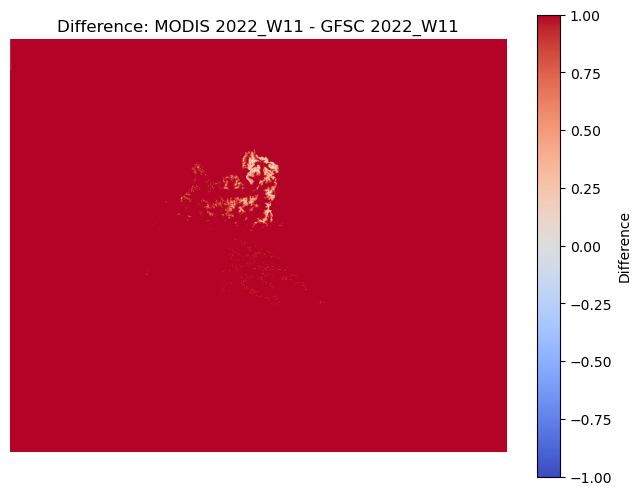

In [4]:
from snow_processing import visual_compare_rasters

week = "2022_W11"

visual_compare_rasters(
    raster_path1=r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\MODIS\2022_W11.tif",
    raster_path2=r"E:\ALIGNED\ToMODIS\GFSC\2022_W11.tif",
    labels=(f"MODIS {week}", f"GFSC {week}"),
    difference=True,
    downsample=5
)



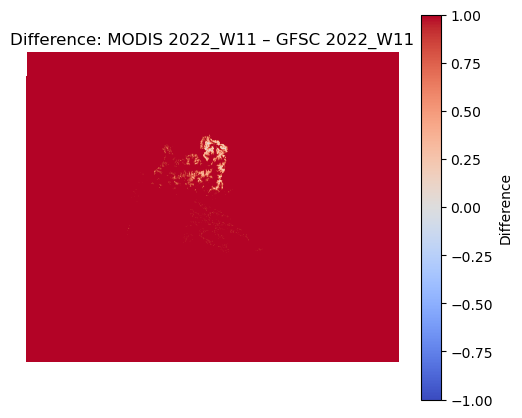

In [5]:
from snow_processing import visual_compare_rasters_strict

week = "2022_W11"
visual_compare_rasters_strict(
    raster_path1=r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\MODIS\2022_W11.tif",
    raster_path2=r"E:\ALIGNED\ToMODIS\GFSC\2022_W11.tif",
    labels       = (f"MODIS {week}", f"GFSC {week}"),
    difference   = True,
    downsample   = 5
)


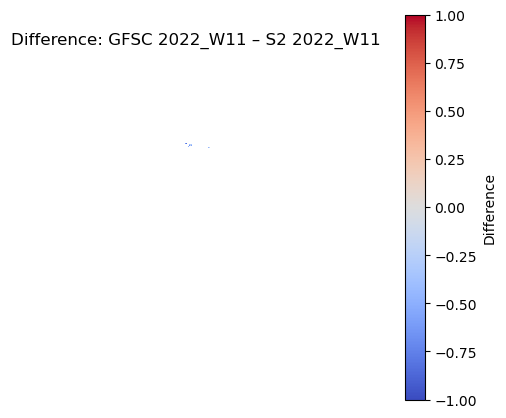

In [6]:
from snow_processing import visual_compare_rasters_strict

week = "2022_W11"
visual_compare_rasters_strict(
    raster_path1=r"E:\ALIGNED\ToMODIS\GFSC\2022_W11.tif",
    raster_path2=r"E:\ALIGNED\ToMODIS\S2\2022_W11.tif",
    labels       = (f"GFSC {week}", f"S2 {week}"),
    difference   = True,
    downsample   = 5
)


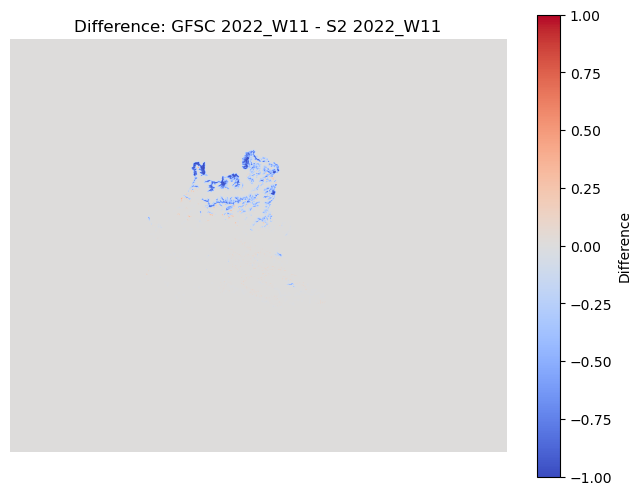

In [7]:
from snow_processing import visual_compare_rasters

week = "2022_W11"

visual_compare_rasters(
    raster_path1=r"E:\ALIGNED\ToMODIS\GFSC\2022_W11.tif",
    raster_path2=r"E:\ALIGNED\ToMODIS\S2\2022_W11.tif",
    labels=(f"GFSC {week}", f"S2 {week}"),
    difference=True,
    downsample=5
)


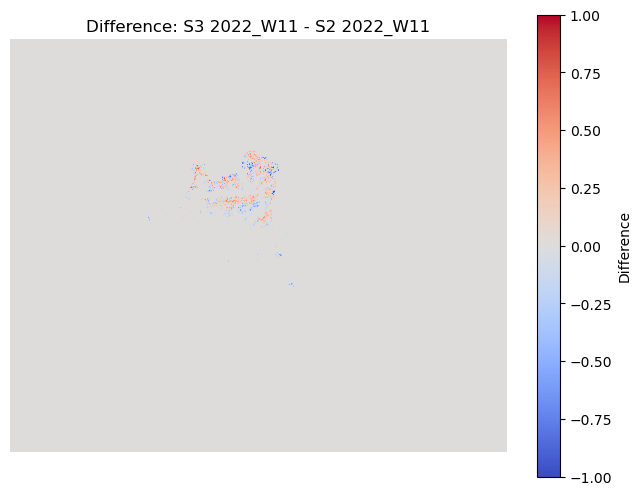

In [21]:
from snow_processing import visual_compare_rasters

week = "2022_W11"

visual_compare_rasters(
    raster_path1=r"E:\ALIGNED\ToMODIS\S3\2022_W11.tif",
    raster_path2=r"E:\ALIGNED\ToMODIS\S2\2022_W11.tif",
    labels=(f"S3 {week}", f"S2 {week}"),
    overlay=True,
    difference=True,
    downsample=2
)


In [9]:
from snow_processing import calculate_agreement
import rasterio
import numpy as np

rp1=r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\MODIS\2022_W11.tif"
rp2=r"E:\ALIGNED\ToMODIS\GFSC\2022_W11.tif"

stats = calculate_agreement(rp1, rp2)
print(stats)

# and compute GFSC-only snow:
with rasterio.open(rp1) as m, rasterio.open(rp2) as g:
    m1 = m.read(1)==1
    g1 = g.read(1)==1
    gfsc_only = np.count_nonzero((~m1 & g1))
    modis_only= np.count_nonzero((m1 & ~g1))
    
print("GFSC-only snow pixels:", gfsc_only)
print("MODIS-only snow pixels:", modis_only)

{'agreement_pct': 0.29278692807866247, 'total_pixels': 751240506, 'agree_pixels': 2199534}
GFSC-only snow pixels: 0
MODIS-only snow pixels: 749040972


In [10]:
from snow_processing import calculate_agreement
import rasterio
import numpy as np

rp1=r"E:\ALIGNED\ToMODIS\S2\2022_W11.tif"
rp2=r"E:\ALIGNED\ToMODIS\GFSC\2022_W11.tif"

stats = calculate_agreement(rp1, rp2)
print(stats)

# and compute GFSC-only snow:
with rasterio.open(rp1) as m, rasterio.open(rp2) as g:
    m1 = m.read(1)==1
    g1 = g.read(1)==1
    gfsc_only = np.count_nonzero((~m1 & g1))
    s2_only= np.count_nonzero((m1 & ~g1))
    
print("GFSC-only snow pixels:", gfsc_only)
print("S2-only snow pixels:", s2_only)

{'agreement_pct': 99.4978029046799, 'total_pixels': 751240506, 'agree_pixels': 747467798}
GFSC-only snow pixels: 470626
S2-only snow pixels: 3302082


In [20]:
import rasterio, numpy as np
with rasterio.open(r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\MODIS\2023_W08.tif") as src:
    arr = src.read(1)
    print(np.unique(arr)[:10])  # first few unique values


[0 1]


In [19]:
import rasterio, numpy as np
with rasterio.open(r"E:\ALIGNED\ToMODIS\GFSC\2023_W08.tif") as src:
    arr = src.read(1)
    print(np.unique(arr)[:10])  # first few unique values


[0 1]


In [17]:
import rasterio, numpy as np
with rasterio.open(r"E:\ALIGNED\ToMODIS\S2\2023_W08.tif") as src:
    arr = src.read(1)
    print(np.unique(arr)[:10])  # first few unique values


[0 1]


In [18]:
import rasterio, numpy as np
with rasterio.open(r"E:\ALIGNED\ToMODIS\S3\2023_W08.tif") as src:
    arr = src.read(1)
    print(np.unique(arr)[:10])  # first few unique values


[0 1]


In [13]:
# ─────────────────────────────────────────────────────────────────────────────
# 1.  QUICK  DIAGNOSTICS  FOR  ONE  WEEK   (works with any two rasters)
# -----------------------------------------------------------------------------
import rasterio
import numpy as np
import pandas as pd

def raster_quick_stats(path):
    """Return nodata value, unique values and counts (clipped to 20 entries)."""
    with rasterio.open(path) as src:
        data = src.read(1)
        nodata = src.nodata
    # count occurrences
    vals, counts = np.unique(data, return_counts=True)
    tbl = pd.DataFrame({"value": vals, "count": counts})
    return nodata, tbl.head(20)

# ➤  provide the paths you just used in visual_compare_rasters_strict
week   = "2023_W08"
modis  = fr"F:\GeoinformaticsProject\Data\Processed\WEEKLY\MODIS\2023_W08.tif"
gfsc   = fr"E:\ALIGNED\ToMODIS\GFSC\2023_W08.tif"
s2     = fr"E:\ALIGNED\ToMODIS\S2\2023_W08.tif"
s3     = fr"E:\ALIGNED\ToMODIS\S3\2023_W08.tif"

for name, path in [("MODIS", modis), ("GFSC", gfsc), ("S2", s2), ("S3", s3)]:
    nodata, head = raster_quick_stats(path)
    print(f"\n{name}  ─ nodata = {nodata}")
    print(head)

# ─────────────────────────────────────────────────────────────────────────────
# 2.  CHECK  THAT  ALL  DATASETS  OVERLAP  AFTER  ALIGNMENT
# -----------------------------------------------------------------------------
from rasterio.windows import from_bounds

def intersection_bounds(src1, src2):
    minx = max(src1.bounds.left,   src2.bounds.left)
    miny = max(src1.bounds.bottom, src2.bounds.bottom)
    maxx = min(src1.bounds.right,  src2.bounds.right)
    maxy = min(src1.bounds.top,    src2.bounds.top)
    if (minx >= maxx) or (miny >= maxy):
        return None
    return (minx, miny, maxx, maxy)

with rasterio.open(modis) as m, rasterio.open(gfsc) as g:
    inter = intersection_bounds(m, g)
    print("\nMODIS vs GFSC intersection:", inter)
    if inter is not None:
        win = from_bounds(*inter, transform=m.transform)
        print("→ pixel window size (rows, cols):", (win.height, win.width))



MODIS  ─ nodata = 255.0
   value      count
0      0      63960
1      1  751176546

GFSC  ─ nodata = 255.0
   value      count
0      0  750066814
1      1    1173692

S2  ─ nodata = 255.0
   value      count
0      0  745954998
1      1    5285508

S3  ─ nodata = 255.0
   value      count
0      0  744832056
1      1    6408450

MODIS vs GFSC intersection: (299725.1480286992, 4799686.739310687, 900165.1480286992, 5300146.739310687)
→ pixel window size (rows, cols): (np.float64(25023.0), np.float64(30022.000000000007))


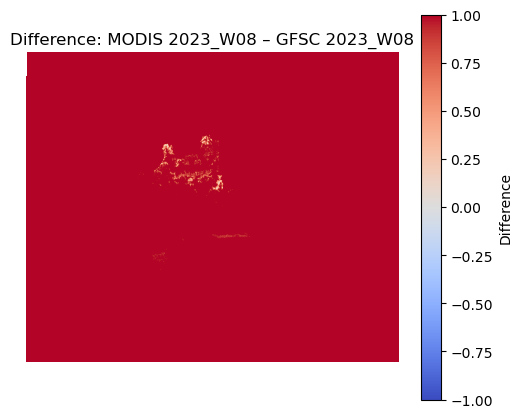

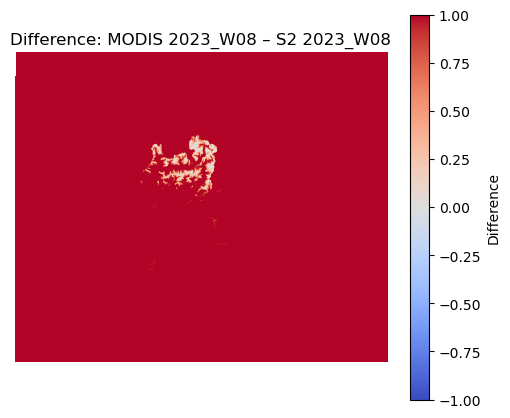

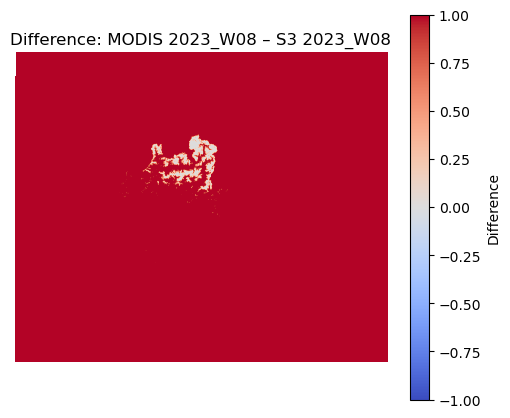

In [14]:
# --- user parameters ---
week     = "2023_W08"
modis    = fr"F:\GeoinformaticsProject\Data\Processed\WEEKLY\MODIS\2023_W08.tif"
gfsc     = fr"E:\ALIGNED\ToMODIS\GFSC\2023_W08.tif"
s2       = fr"E:\ALIGNED\ToMODIS\S2\2023_W08.tif"
s3       = fr"E:\ALIGNED\ToMODIS\S3\2023_W08.tif"

from snow_processing import visual_compare_rasters_strict

# ── MODIS vs GFSC ──────────────────────────────────────────
visual_compare_rasters_strict(
    raster_path1 = modis,
    raster_path2 = gfsc,
    labels       = (f"MODIS {week}", f"GFSC {week}"),
    difference   = True,   # set False for side‑by‑side
    downsample   = 5
)

# ── MODIS vs S2 ────────────────────────────────────────────
visual_compare_rasters_strict(
    raster_path1 = modis,
    raster_path2 = s2,
    labels       = (f"MODIS {week}", f"S2 {week}"),
    difference   = True,
    downsample   = 5
)

# ── MODIS vs S3 ────────────────────────────────────────────
visual_compare_rasters_strict(
    raster_path1 = modis,
    raster_path2 = s3,
    labels       = (f"MODIS {week}", f"S3 {week}"),
    difference   = True,
    downsample   = 5
)
